In [1]:
import geopandas as gpd
from shapely.geometry import MultiLineString
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyproj import CRS

drive.mount('/content/drive')

# Ruta al archivo shapefile
shp_path =  '/content/drive/MyDrive/Tesis/Datos/v_camineria_nacional.shp'
roads = gpd.read_file(shp_path)
roads = roads[~roads.geometry.isnull()]
roads = roads.to_crs(epsg=32721)

Mounted at /content/drive


In [2]:
route_5 = roads[roads['numero'] == 5].geometry
ruta5 = route_5.geometry.to_list()

In [3]:
intersections_list = []
for index, row in roads.iterrows():
    geometri = row['geometry']
    if not geometri in ruta5:
      for tramo in ruta5:
        intersection = geometri.intersection(tramo)
        if not intersection.is_empty:
          intersections_list.append(intersection)
          break
intersections_gdf = gpd.GeoDataFrame(geometry=intersections_list, crs=roads.crs)

In [4]:
display(intersections_gdf.head())
print(f"Number of intersection geometries found: {len(intersections_gdf)}")

,geometry
0,POINT (627661.97 6542289.464)
1,POINT (566940.451 6179707.939)
2,POINT (568194.513 6154386.359)
3,POINT (566886.62 6179648.682)
4,POINT (569044.045 6419264.5)


Number of intersection geometries found: 429


In [5]:
escuelas_shp_path =  '/content/drive/MyDrive/Tesis/Datos/ceip-escuela/CEIP.shp'
escuelas = gpd.read_file(escuelas_shp_path)
escuelas = escuelas.to_crs(epsg=32721)
escuelas = escuelas[~escuelas.geometry.isnull()]
escuelas = escuelas[escuelas["Area"] == "RURAL"] #solo considerar escuelas rurales


route5_buffer = route_5.buffer(6000)
route5_buffer = gpd.GeoDataFrame(geometry=route5_buffer, crs=route_5.crs)
escuelas_cercanas = gpd.sjoin(escuelas, route5_buffer, how="inner", predicate='intersects')

#display(escuelas_cercanas.head())
print(f"Numeros de escuelas rurales cercas a ruta 5: {len(escuelas_cercanas)}")

Numeros de escuelas rurales cercas a ruta 5: 1277


In [6]:
PATH_LOCALIDADES = "/content/drive/MyDrive/Tesis/Datos/merged_localidades.csv"  # ajustá si cambia
loc = pd.read_csv(PATH_LOCALIDADES)
loc = loc.rename(columns={"size":"poblacion"})
loc.dropna(subset=['LON', 'LAT'], inplace=True)
gdf_localidades = gpd.GeoDataFrame(
    loc,
    geometry=gpd.points_from_xy(loc["LON"], loc["LAT"]),
    crs=4326
).to_crs(epsg=32721)
localidades_cercanas =  gpd.sjoin(gdf_localidades, route5_buffer, how="inner", predicate='intersects')

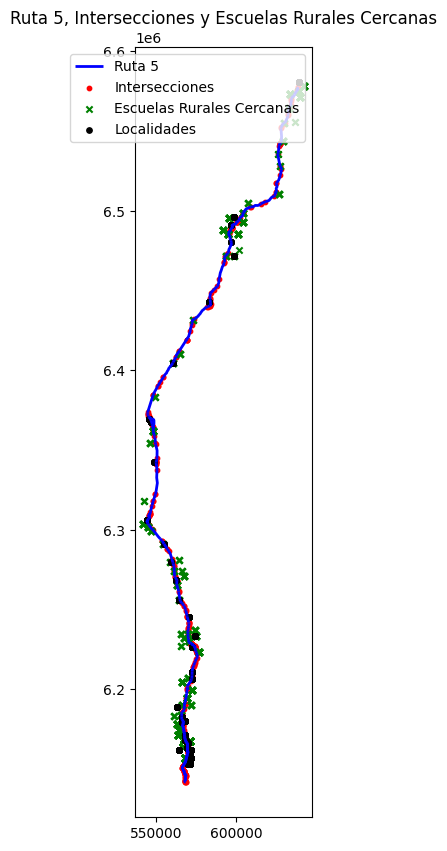

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
route_5.plot(ax=ax, color='blue', linewidth=2, label='Ruta 5')
intersections_gdf.plot(ax=ax, color='red', marker='o', markersize=10, label='Intersecciones')
escuelas_cercanas.plot(ax=ax, color='green', marker='x', markersize=20, label='Escuelas Rurales Cercanas')
localidades_cercanas.plot(ax=ax, color='black', marker='o', markersize=15, label='Localidades')
ax.legend()
ax.set_title('Ruta 5, Intersecciones y Escuelas Rurales Cercanas')
ax.set_title('Ruta 5, Intersecciones y Escuelas Rurales Cercanas')
plt.show()

# Creacion de sistema optimo

In [8]:
# @title Poi's finales (escuelas, intersecciones y localidades)
# Ensure intersections_gdf only contains Point geometries by taking the centroid
intersections_gdf_points = intersections_gdf.geometry.apply(lambda geom: geom.centroid if not geom.is_empty else None).dropna()
intersections_gdf_points = gpd.GeoDataFrame(geometry=intersections_gdf_points, crs=intersections_gdf.crs)

# Concatenate all point geometries into gdf_POI
gdf_POI = pd.concat([localidades_cercanas, escuelas_cercanas, intersections_gdf_points], ignore_index=True)
gdf_POI = gpd.GeoDataFrame(gdf_POI, geometry=gdf_POI.geometry, crs=localidades_cercanas.crs)

In [9]:
# @title creacion de paradas

import math
from dataclasses import dataclass
from typing import Tuple, Optional
from shapely.ops import unary_union, linemerge, snap
from shapely.geometry import LineString, MultiLineString, Point
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans

def _merged_route_line(roads: gpd.GeoDataFrame,S = 100)-> list:
    u = unary_union(roads.geometry.values)
    u = snap(u, u, S)       # cierra micro-gaps reales
    merged = linemerge(u)
    parts = merged.geoms if isinstance(merged, MultiLineString) else [merged]
    lines = sorted(list(merged.geoms), key=lambda g: (g.bounds[1], g.bounds[0]))
    return lines

def points_every(line, step) -> list:
    L = line.length
    d = 0.0
    pts = []
    while d <= L:
        pts.append(line.interpolate(d))
        d += step
    return pts

def _snap_point_to_line_and_m(point: Point, line) -> Tuple[Point, float]:
    """
    Snaps a point to a LineString or MultiLineString and returns the snapped point
    and the m-value (distance along the line from the start).
    """
    from shapely.ops import nearest_points

    if isinstance(line, LineString):
        snapped = nearest_points(point, line)[0]
        coords = list(line.coords)
        dists = [0.0]
        for i in range(1, len(coords)):
            dists.append(dists[-1] + Point(coords[i-1]).distance(Point(coords[i])))
        total_len = dists[-1]
        min_dist = float("inf"); seg_idx = 0
        for i in range(1, len(coords)):
            seg = LineString([coords[i-1], coords[i]])
            d = snapped.distance(seg)
            if d < min_dist:
                min_dist = d; seg_idx = i
        a = Point(coords[seg_idx-1]); b = Point(coords[seg_idx])
        ab = np.array([b.x - a.x, b.y - a.y])
        ap = np.array([snapped.x - a.x, snapped.y - a.y])
        seg_len = np.linalg.norm(ab)
        t = 0.0 if seg_len == 0 else np.clip(np.dot(ap, ab) / (seg_len**2), 0, 1)
        m = dists[seg_idx-1] + t * seg_len
        return snapped, m

    elif isinstance(line, MultiLineString):
        min_dist = float("inf")
        best_snapped = None
        best_m = 0.0
        total_len_so_far = 0.0

        for segment in line.geoms:
            try:
                snapped_seg, m_seg = _snap_point_to_line_and_m(point, segment)
                dist_to_segment = point.distance(snapped_seg)

                if dist_to_segment < min_dist:
                    min_dist = dist_to_segment
                    best_snapped = snapped_seg
                    # Calculate m-value along the *entire* MultiLineString
                    best_m = total_len_so_far + m_seg
            except Exception:
                # Handle cases where snapping to a small segment might fail
                pass
            total_len_so_far += segment.length

        if best_snapped is None:
             # If snapping failed for all segments, return a default or raise error
             # For now, return the original point and 0 m-value as a fallback
             return point, 0.0 # Or raise an informative error

        return best_snapped, best_m

    else:
        raise TypeError("Input geometry must be a LineString or MultiLineString")


# --- Candidate generation ---
#espaciar cada 3 km

def make_candidates_along_route(roads: gpd.GeoDataFrame, spacing_m: int = 3000):
    route_line_segments = _merged_route_line(roads)
    pts = []
    Distancia = 0
    for tramo in route_line_segments:
        if Distancia > spacing_m:
          puntos = points_every(tramo, spacing_m)
          for punto in puntos:
              pts.append(punto)
          Distancia = 0
        else:
          Distancia += tramo.length

    return gpd.GeoDataFrame({"cand_id": range(len(pts))}, geometry=pts, crs=roads.crs)

def expand_candidates(candidates, roads, expand_m: int = 500):
    route_line_segments = _merged_route_line(roads)
    new_pts = []
    # Consider a small buffer for proximity check
    buffer_distance = 1.0 # meters, adjust as needed

    for p in candidates.geometry:
        for tramo in route_line_segments:
            # Check if the point is within a small buffer of the line segment
            if p.within(tramo.buffer(buffer_distance)):
                _, m = _snap_point_to_line_and_m(p, tramo)
                for delta in (-expand_m, 0, +expand_m):
                    md = max(0, min(tramo.length, m + delta))
                    new_pts.append(tramo.interpolate(md))
                # Once a segment is found, no need to check others for this point
                break

    return gpd.GeoDataFrame(geometry=new_pts, crs=roads.crs).drop_duplicates(ignore_index=True)



# --- Clustering ---
def kmeans_centers(demand_pts: gpd.GeoDataFrame, k: int):
    X = np.c_[demand_pts.geometry.x, demand_pts.geometry.y]
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(X)
    centers = km.cluster_centers_

    # Ensure counts array has the same length as centers array
    # This handles cases where KMeans finds fewer distinct clusters than requested 'k'
    num_centers = len(centers)
    # Create a Categorical Series for labels with categories up to num_centers - 1
    categorical_labels = pd.Categorical(labels, categories=np.arange(num_centers))
    counts = pd.Series(categorical_labels).value_counts(sort=False).to_numpy()

    return gpd.GeoDataFrame({"weight": counts}, geometry=[Point(xy) for xy in centers], crs=demand_pts.crs)


def wpdm_scores(candidates, centers, shortlist_k: int = 3, rank_weights=(1.0, 0.5, 0.2)):
    """
    candidates: GeoSeries (puntos) o array de floats (distancias euclídeas si no es Geo)
    centers: GeoDataFrame con columnas: geometry (Point) y weight (float)
    """
    shortlist_k = int(shortlist_k)
    if shortlist_k < 1:
        raise ValueError("shortlist_k debe ser >= 1")

    # Asegurar pesos suficientes (relleno con 0: más allá de los 3 primeros no suma)
    rweights = np.array(rank_weights, dtype=float)
    if len(rweights) < shortlist_k:
        rweights = np.pad(rweights, (0, shortlist_k - len(rweights)), constant_values=0.0)

    scores = np.zeros(len(candidates), dtype=float)

    use_geo = hasattr(candidates, "distance") and hasattr(centers, "geometry")
    center_weights = np.asarray(centers["weight"], dtype=float)

    for i, w in enumerate(center_weights):
        if use_geo:
            dists = np.asarray(candidates.distance(centers.geometry.iloc[i]))
        else:
            # si no es Geo, asumir candidatos y centers son arrays/series numéricas comparables
            dists = np.abs(np.asarray(candidates) - np.asarray(centers.iloc[i]))

        # Elegir los k más cercanos y ordenarlos por distancia
        k = min(shortlist_k, len(dists))
        idx = np.argpartition(dists, k-1)[:k]
        idx = idx[np.argsort(dists[idx])]
        scores[idx] += w * rweights[:k]

    return pd.DataFrame({"score": scores})

def select_top_n_with_min_spacing(
    candidates: gpd.GeoDataFrame,
    scores: pd.DataFrame,
    n: int,
    min_spacing_m: float = 100.0,
    score_col: str = "score",
    metric_crs: str = "EPSG:32721",  # UTM 21S (Uruguay): distancias en metros
):
    crs_obj = CRS.from_user_input(candidates.crs)
    g = candidates
    order = (
        pd.DataFrame({"idx": np.arange(len(g)), "score": scores[score_col].to_numpy()})
        .dropna(subset=["score"])
        .sort_values("score", ascending=False)["idx"]
        .to_list()
    )
    chosen = []
    for idx in order:
        if len(chosen) >= n:
            print("SALIO DONDE QUEREMOS")
            break
        geom = g.geometry.iloc[idx]
        # distancia mínima al conjunto ya elegido
        if not chosen:
            chosen.append(idx)
            continue
        dmin = min(geom.distance(g.geometry.iloc[j]) for j in chosen)
        if dmin >= float(min_spacing_m):
            chosen.append(idx)

    out = candidates.iloc[chosen].copy()
    out[score_col] = scores.iloc[chosen][score_col].to_numpy()
    return out.sort_values(score_col, ascending=False).reset_index(drop=True)

In [10]:
# @title AHP
RI_TABLE = {
    1: 0.00, 2: 0.00, 3: 0.58, 4: 0.90, 5: 1.12,
    6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45,
    10: 1.49, 11: 1.51, 12: 1.48, 13: 1.56, 14: 1.57, 15: 1.59
}

def build_pairwise_matrix(items, comparisons, check_scale=True):
    labels = list(items)
    n = len(labels)
    idx = {name: k for k, name in enumerate(labels)}
    A = np.ones((n, n), dtype=float)
    for (i, j), v in comparisons.items():
        if i not in idx or j not in idx:
            raise ValueError(f"Unknown item in comparison: {(i,j)}")
        if v <= 0:
            raise ValueError("Comparison values must be positive.")
        if check_scale and not (1/9 <= v <= 9):
            print(f"Warning: value {v} for ({i},{j}) is outside Saaty 1..9 (or reciprocal). Proceeding.")
        A[idx[i], idx[j]] = v
        A[idx[j], idx[i]] = 1.0 / v
    np.fill_diagonal(A, 1.0)
    return A, labels

def ahp_weights(A, method="eigen"):
    A = np.asarray(A, dtype=float)
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("A must be a square matrix.")
    n = A.shape[0]

    if method == "eigen":
        vals, vecs = np.linalg.eig(A)
        idx = np.argmax(vals.real)
        w = vecs[:, idx].real
        w = np.abs(w)
    elif method == "geom":
        w = np.prod(A, axis=1) ** (1.0 / n)
    else:
        raise ValueError("method must be 'eigen' or 'geom'")

    w = w / w.sum()

    Aw = A @ w
    lambda_max = float((Aw / w).mean())
    CI = (lambda_max - n) / (n - 1) if n > 1 else 0.0
    RI = RI_TABLE.get(n, RI_TABLE[max(k for k in RI_TABLE if k <= n)])
    CR = CI / RI if RI > 0 else 0.0
    return {"weights": w, "lambda_max": lambda_max, "CI": CI, "CR": CR}

# ejemplo_ahp.py
import numpy as np

# Criterios
labels = ["POI_number", "Stops_spacing", "Stop_POI_distance"]

# Comparaciones por pares (escala de Saaty)
comparisons = {
    ("POI_number", "Stops_spacing"): 3,    # POI moderadamente > spacing
    ("POI_number", "Stop_POI_distance"): 2,# POI fuertemente > dist
    ("Stops_spacing", "Stop_POI_distance"): 0.5  # spacing ligeramente > dist
}

A, _ = build_pairwise_matrix(labels, comparisons)
res = ahp_weights(A, method="eigen")
pesos = np.round(res["weights"])
print("Matriz A:\n", np.round(A, 3))
print("Pesos:", np.round(res["weights"], 6))
print("lambda_max:", round(res["lambda_max"], 6), "CI:", round(res["CI"], 6), "CR:", round(res["CR"], 6))

Matriz A:
 [[1.    3.    2.   ]
 [0.333 1.    0.5  ]
 [0.5   2.    1.   ]]
Pesos: [0.539615 0.163424 0.296961]
lambda_max: 3.009203 CI: 0.004601 CR: 0.007933


In [11]:
# @title Criterio AHP
@dataclass
class AHPWeights:
    poi_number: float = 0.539615
    stop_spacing: float = 0.163424
    poi_distance: float = 0.296961

def evaluate_stops_ahp(stops, roads, pois, weights=AHPWeights()):
    # Get the merged route geometry (can be LineString or MultiLineString)
    route_geometry = unary_union(roads.geometry.values)

    # Calculate m-values by snapping each stop to the route geometry
    mvals = stops.geometry.apply(lambda p: _snap_point_to_line_and_m(p, route_geometry)[1]).sort_values().to_numpy()

    spacings = np.diff(mvals) if len(mvals)>1 else [0]
    sp_full = np.r_[spacings[0], (spacings[:-1]+spacings[1:])/2.0, spacings[-1]] if len(mvals)>1 else [0]*len(mvals)
    #distancias entre paradas
    #distancias a mirar en el futuro, y adaptarlas segun poblacion
    spacing_score = pd.Series([1.0 if 2000<d<=15000 else 0.5 if d<=25000 else 0.2 for d in sp_full], index=stops.index)
    counts = stops.buffer(5000).apply(lambda b: pois.within(b).sum())
    #cantidad de localidades de cercanas
    poi_num_score = counts.apply(lambda c: 0.3 if c<=1 else 0.6 if c<=3 else 0.8 if c<=10 else 1.0)
    poi_dist_score = []
    #distancia promedio a las localidades mas cercanas
    for _, s in stops.iterrows():
        d = pois.distance(s.geometry)
        mask = d <= 5000
        if mask.any():
            avg = d[mask].mean()
            sc = 1.0 if avg<=2000 else 0.7 if avg<=3500 else 0.5
        else: sc = 0.5
        poi_dist_score.append(sc)
    poi_dist_score = pd.Series(poi_dist_score, index=stops.index)
    #calcula la metrica
    total = (weights.poi_number*poi_num_score +
             weights.stop_spacing*spacing_score +
             weights.poi_distance*poi_dist_score)
    df = pd.DataFrame({"poi_num": poi_num_score, "spacing": spacing_score,
                       "poi_dist": poi_dist_score, "total_score": total})
    df.attrs["overall_mean"] = float(total.mean())
    return df

def optimize_single_corridor(roads, demand_pts, pois, n_new_stops, k_clusters=None,
                             spacing_m=3000, expand_m=1500, shortlist_k=3, min_spacing_m=100):
    candidates = make_candidates_along_route(roads, spacing_m)
    print(f"Candidates: {len(candidates)}")
    candidates2 = expand_candidates(candidates, roads, expand_m)
    print(f"2 Candidates: {len(candidates2)}")
    if k_clusters is None:
        k_clusters = min(20, max(5, int(np.sqrt(len(demand_pts)))))
    centers = kmeans_centers(demand_pts, k=k_clusters)
    sc = wpdm_scores(candidates2, centers, shortlist_k) # Removed 'roads' argument
    new_stops = select_top_n_with_min_spacing(candidates2, sc, n=n_new_stops, min_spacing_m=min_spacing_m)
    print(f"paradas finales: {len(new_stops)}")
    return new_stops, sc

In [12]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.7 MB/s eta 0:00:00


In [13]:
# @title Optimizacion (Yu)
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

def objective(trial: optuna.Trial):
    # --- ESPACIO RURAL ---
    spacing_m     = trial.suggest_int("spacing_m", 2000, 40000)      # separación base de candidatos
    expand_m      = trial.suggest_int("expand_m", min(1000,spacing_m//3), min(3500, spacing_m//2))         # micro-ajuste local
    shortlist_k   = trial.suggest_categorical("shortlist_k", [2,3,4,5,6,7])
 #   min_spacing_m = trial.suggest_int("min_spacing_m", 2000, 1000)
    paradas = trial.suggest_int("paradas", 100, 350)

    # k_clusters moderado (rural): entre ~sqrt(N) N
    lo_k = np.sqrt(len(gdf_POI))
    hi_k = len(gdf_POI)//2
    k_clusters   = trial.suggest_int("k_clusters", lo_k, hi_k)

    new_stops_try, wpdm_try = optimize_single_corridor(
        roads=route_5,
        demand_pts=gdf_POI,
        pois=gdf_POI,           # si por ahora POIs=demanda como proxy, mantenemos consistencia
        n_new_stops=paradas,
        k_clusters=k_clusters,
        spacing_m=spacing_m,
        expand_m=expand_m,
        shortlist_k=shortlist_k,
        min_spacing_m=100
    )
    eval_try = evaluate_stops_ahp(new_stops_try, route_5, gdf_POI)
    score_mean = float(eval_try["total_score"].mean())
    return score_mean
def Optimizar_Yu():
  study = optuna.create_study(
      direction="maximize",
      sampler=TPESampler(seed=42),
      pruner=MedianPruner(n_warmup_steps=10),
      study_name="ruta8_rural_wpdm_ahp"
  )

  study.optimize(objective, n_trials=300, show_progress_bar=True)

[I 2025-11-09 01:13:44,224] Trial 258 finished with value: 0.8495386695945947 and parameters: {'spacing_m': 2047, 'expand_m': 959, 'shortlist_k': 3, 'paradas': 148, 'k_clusters': 373}. Best is trial 258 with value: 0.8495386695945947.


In [14]:
# @title Optimizacion usando algoritmo genetico y 120 paradas

!pip install deap --quiet


import numpy as np, random, multiprocessing as mp
from functools import lru_cache
from deap import base, creator, tools, algorithms

# --- Hiperparámetros (ajustables) ---
N = 120              # número de paradas
dmin = 100       # separación mínima (m)
POP = 120           # tamaño población
GEN = 60            # generaciones máx
CX_P = 0.7          # prob cruce
MUT_P = 0.3         # prob mutación
TOUR = 3            # torneo
EARLY_NI = 10       # cortar si no mejora en 10 gens
candidates = make_candidates_along_route(route_5, dmin)
candidates = candidates.to_crs(32721)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 4.2 MB/s eta 0:00:00


In [17]:
# @title algoritmo genetico
# ====== PRE-COMPUTOS ======
ALL_IDX = np.arange(len(candidates), dtype=int)

def _precompute_too_close_neighbors(candidates, dmin):
    from sklearn.neighbors import KDTree
    xy = np.array([(p.x, p.y) for p in candidates.geometry.to_numpy()], dtype=float)
    tree = KDTree(xy)
    idxs = tree.query_radius(xy, r=dmin)
    out = []
    for i, arr in enumerate(idxs):
        s = set(arr.tolist())
        s.discard(i)
        out.append(s)
    return out
too_close = _precompute_too_close_neighbors(candidates, dmin)
too_close_sets = [set(s) for s in too_close]

# ====== FITNESS con caché y penalización ======
try:
    creator.FitnessMax
except AttributeError:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

@lru_cache(maxsize=10000)
def _fitness_from_tuple(sol_tuple):
    idx = np.fromiter(sol_tuple, dtype=int)
    chosen = set(idx.tolist())
    # Chequeo O(N * grado) muy rápido
    for i in idx:
        if too_close_sets[i] & chosen:
            return -1e9  # penalización dura: evita llamar AHP
    # Solo si es factible, llamamos a tu función cara:
    sc = evaluate_stops_ahp(candidates.iloc[idx], roads=route_5, pois=gdf_POI)
    return float(np.mean(sc["total_score"]))

def evaluate_individual(ind):
    return (_fitness_from_tuple(tuple(ind)),)

# ====== OPERADORES FEASIBLES ======
def init_individual():
    ind, available = [], set(ALL_IDX.tolist())
    while len(ind) < N and available:
        i = random.sample(list(available), 1)[0]
        ind.append(i)
        # bloquear vecinos a < dmin
        available -= (too_close_sets[i] | {i})
    # reparación greedy si faltan genes
    if len(ind) < N:
        rem = list(set(ALL_IDX) - set(ind))
        random.shuffle(rem)
        for j in rem:
            if all((j not in too_close_sets[k]) for k in ind):
                ind.append(j)
                if len(ind) == N: break
    return creator.Individual(sorted(ind))

def cx_repair(ind1, ind2):
    # mezcla por unión parcial y repara factibilidad
    pool = list(set(ind1) | set(random.sample(ind2, k=N//2)))
    child = []
    used = set()
    for i in sorted(pool):
        if all((i not in too_close_sets[j]) for j in child):
            child.append(i); used.add(i)
        if len(child) == N: break
    if len(child) < N:
        rest = list(set(ALL_IDX) - used)
        random.shuffle(rest)
        for i in rest:
            if all((i not in too_close_sets[j]) for j in child):
                child.append(i)
                if len(child) == N: break
    ind1[:] = sorted(child)
    # hijo 2: simétrico pero con roles invertidos
    pool2 = list(set(ind2) | set(random.sample(ind1, k=N//2)))
    child2, used2 = [], set()
    for i in sorted(pool2):
        if all((i not in too_close_sets[j]) for j in child2):
            child2.append(i); used2.add(i)
        if len(child2) == N: break
    if len(child2) < N:
        rest2 = list(set(ALL_IDX) - used2)
        random.shuffle(rest2)
        for i in rest2:
            if all((i not in too_close_sets[j]) for j in child2):
                child2.append(i)
                if len(child2) == N: break
    ind2[:] = sorted(child2)
    return ind1, ind2

def mut_targeted(ind, k=None):
    if k is None: k = max(1, N//10)
    cur = set(ind)
    # remover hasta k genes más conflictivos
    for _ in range(k):
        conflicts = [(i, len(too_close_sets[i] & cur)) for i in list(cur)]
        i_bad, cmax = max(conflicts, key=lambda t: t[1])
        if cmax == 0: break
        cur.remove(i_bad)
    # rellenar con índices que no choquen
    pool = list(set(ALL_IDX) - cur)
    random.shuffle(pool)
    for i in pool:
        if len(cur) >= N: break
        if all((i not in too_close_sets[j]) for j in cur):
            cur.add(i)
    ind[:] = sorted(list(cur))[:N]
    return (ind,)

toolbox = base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", cx_repair)
toolbox.register("mutate", mut_targeted, k=max(1, N//10))
toolbox.register("select", tools.selTournament, tournsize=TOUR)
toolbox.register("evaluate", evaluate_individual)

# Paralelización
pool = mp.Pool(processes=max(1, mp.cpu_count()-1))
toolbox.register("map", pool.map)
# ====== BUCLE EVOLUTIVO con early stopping ======
pop = toolbox.population(n=POP)
hof = tools.HallOfFame(5)
best, no_improve = -np.inf, 0

# ====== CHECKPOINT ======
import pickle, gzip, os
from pathlib import Path

CKPT = Path("/content/drive/MyDrive/Tesis/checkpoints/ga_ruta5_checkpoint.pkl.gz")

def _serialize_pop(pop):
    # Lista de (genes, fitness)
    return [ (list(ind), float(ind.fitness.values[0]) if ind.fitness.valid else None) for ind in pop ]

def _deserialize_pop(serialized):
    pop = []
    for genes, fit in serialized:
        ind = creator.Individual(list(genes))
        if fit is not None:
            ind.fitness.values = (fit,)
        pop.append(ind)
    return pop

def save_ckpt(gen, pop, hof, best, no_improve, rng_state, np_rand_state):
    # Ensure the directory exists
    CKPT.parent.mkdir(parents=True, exist_ok=True)
    payload = {
        "gen": gen,
        "pop": _serialize_pop(pop),
        "hof": _serialize_pop(list(hof)),
        "best": float(best),
        "no_improve": int(no_improve),
        "rng_state": rng_state,
        "np_rand_state": np_rand_state,
        # opcional: cache de fitness si la querés persistir
        # "_fitness_from_tuple_cache": _fitness_from_tuple.cache_info()  # solo info
    }
    with gzip.open(CKPT, "wb") as f:
        pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_ckpt():
    with gzip.open(CKPT, "rb") as f:
        payload = pickle.load(f)
    pop = _deserialize_pop(payload["pop"])
    hof_list = _deserialize_pop(payload["hof"])
    hof = tools.HallOfFame(maxlen=max(1, len(hof_list)))
    for ind in hof_list: hof.insert(ind)
    return (payload["gen"], pop, hof, payload["best"], payload["no_improve"],
            payload["rng_state"], np_rand_state)

def optimizar_GA(CKPT):
  start_gen = 0
  if CKPT.exists():
      (start_gen, pop, hof, best, no_improve, rng_state, np_rand_state) = load_ckpt()
      random.setstate(rng_state)
      np.random.set_state(np_rand_state)
      print(f"Reanudando desde gen {start_gen}, best={best:.6f}")
  else:
      pop = toolbox.population(n=POP)
      hof = tools.HallOfFame(5)
      best, no_improve = -np.inf, 0
      # eval inicial si querés arrancar con fitness válidos
      fits = list(toolbox.map(toolbox.evaluate, pop))
      for ind, fit in zip(pop, fits): ind.fitness.values = fit
      hof.update(pop)
      best = hof[0].fitness.values[0]
      save_ckpt(0, pop, hof, best, no_improve, random.getstate(), np.random.get_state())
      print(f"Inicio en gen 0, best={best:.6f}")

  # ====== BUCLE EVOLUTIVO con checkpoint por generación ======
  for gen in range(start_gen + 1, GEN + 1):
      offspring = tools.selTournament(pop, len(pop), tournsize=TOUR)
      offspring = list(map(creator.Individual, [list(ind) for ind in offspring]))
      offspring = algorithms.varAnd(offspring, toolbox, cxpb=CX_P, mutpb=MUT_P)
      fits = list(toolbox.map(toolbox.evaluate, offspring))
      for ind, fit in zip(offspring, fits): ind.fitness.values = fit

      pop = tools.selBest(pop + offspring, POP)
      hof.update(pop)
      cur = hof[0].fitness.values[0]

      print(f"Gen {gen} | best={cur:.6f}")
      if cur > best: best, no_improve = cur, 0
      else: no_improve += 1

      # Guardar SIEMPRE al final de la generación
      save_ckpt(gen, pop, hof, best, no_improve, random.getstate(), np.random.get_state())

      if no_improve >= EARLY_NI:
          print(f"Early stop en gen {gen} (sin mejora {EARLY_NI} gens).")
          break

  # ====== FIN ======
  best_idx = hof[0]
  best_score = float(best)
  best_solution = candidates.iloc[best_idx].copy()
  print("Mejor score:", best_score)

In [18]:
 optimizar_GA(CKPT)

Inicio en gen 0, best=0.817218
Gen 1 | best=0.824323
Gen 2 | best=0.831270
Gen 3 | best=0.832912
Gen 4 | best=0.832912
Gen 5 | best=0.832912
Gen 6 | best=0.832912
Gen 7 | best=0.832912
Gen 8 | best=0.833497
Gen 9 | best=0.833497
Gen 10 | best=0.833497
Gen 11 | best=0.833497
Gen 12 | best=0.833497
Gen 13 | best=0.833497
Gen 14 | best=0.833497
Gen 15 | best=0.833497
Gen 16 | best=0.833497
Gen 17 | best=0.833497
Gen 18 | best=0.833497
Early stop en gen 18 (sin mejora 10 gens).
Mejor score: 0.8334971591666668
